In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML 
from lr.analysis.util import get_ts_from_results_folder 
from lr.stats.h_testing import get_paired_t_statistic

from glob import glob

# P-value cloud

In [2]:
folder = "snli"

all_paired_t_p_values_snli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_snli.append(paired_t_p_value)
    
all_paired_t_p_values_snli = pd.concat(all_paired_t_p_values_snli, 1)
all_paired_t_p_values_snli.columns = batchs

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


In [3]:
folder = "mnli"

all_paired_t_p_values_mnli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
        
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_mnli.append(paired_t_p_value)
    
all_paired_t_p_values_mnli = pd.concat(all_paired_t_p_values_mnli, 1)
all_paired_t_p_values_mnli.columns = batchs

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


In [4]:
def get_cloud_p_values(p_values_df, alpha=0.05, test_repetitions=5):    
    rhos = p_values_df.index
    mean_p_values = p_values_df.mean(1).values
    error_p_values = p_values_df.std(1).values
    min_p_values  = p_values_df.min(1).values


    alpha_adj = alpha / test_repetitions

    rejected_ids = []
    remain_ids = []

    for i,p in enumerate(min_p_values):
        if p < alpha_adj:
            rejected_ids.append(i)
        else:
            remain_ids.append(i)

    rhos_rejected = rhos[rejected_ids]
    rhos_remain = rhos[remain_ids]
    y_rejected = mean_p_values[rejected_ids]
    y_remain = mean_p_values[remain_ids]
    error_rejected = error_p_values[rejected_ids]
    error_remain = error_p_values[remain_ids]
    return rhos_rejected, rhos_remain, y_rejected, y_remain, error_rejected, error_remain

In [5]:
rhos_rejected_snli, rhos_remain_snli, y_rejected_snli, y_remain_snli, error_rejected_snli, error_remain_snli = get_cloud_p_values(all_paired_t_p_values_snli)
rhos_rejected_mnli, rhos_remain_mnli, y_rejected_mnli, y_remain_mnli, error_rejected_mnli, error_remain_mnli = get_cloud_p_values(all_paired_t_p_values_mnli)

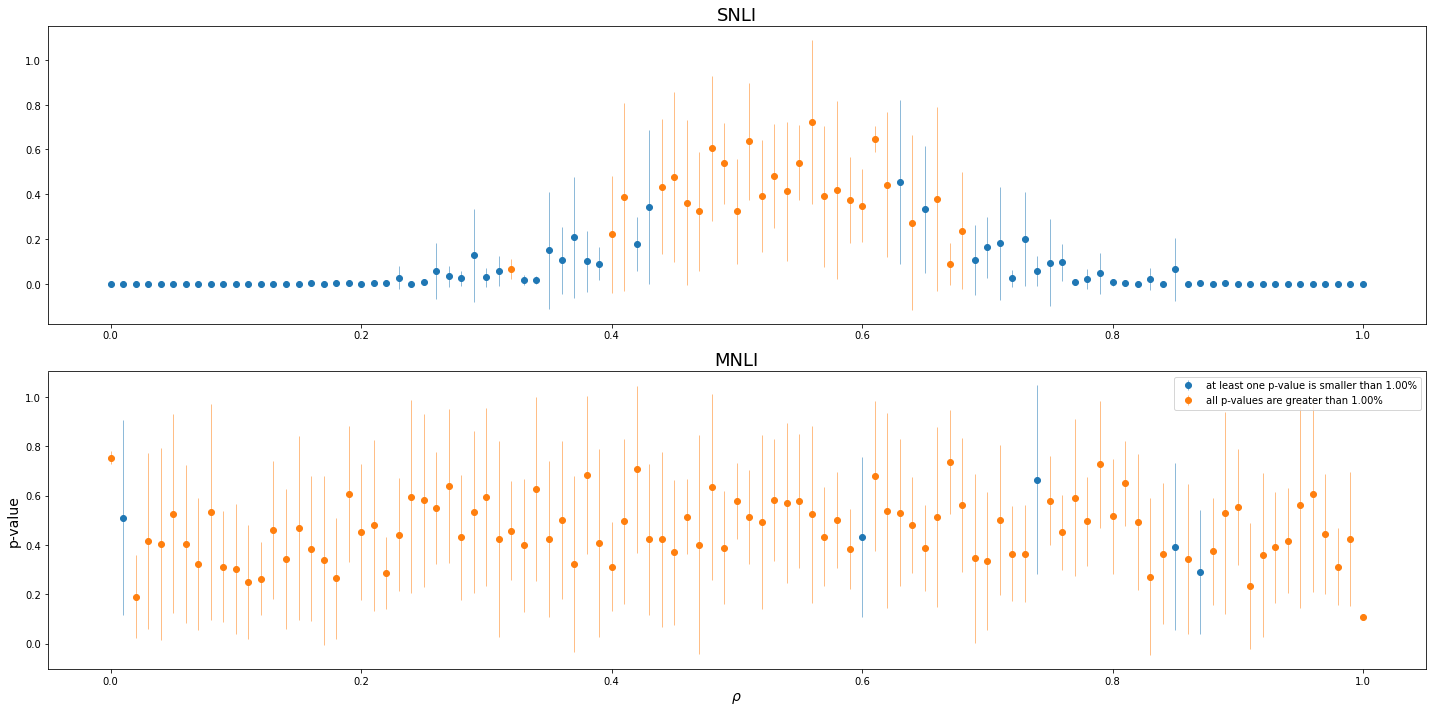

In [6]:
alpha = 0.05
alpha_adj = alpha / test_repetitions



fig, ax = plt.subplots(2,figsize=(20,10))
ax[0].errorbar(rhos_rejected_snli, y_rejected_snli, yerr=error_rejected_snli, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax[0].errorbar(rhos_remain_snli, y_remain_snli, yerr=error_remain_snli, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax[1].errorbar(rhos_rejected_mnli, y_rejected_mnli, yerr=error_rejected_mnli, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax[1].errorbar(rhos_remain_mnli, y_remain_mnli, yerr=error_remain_mnli, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax[1].legend(loc="best");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("p-value", fontsize=14);
ax[1].set_title("MNLI", fontsize=18);
ax[0].set_title("SNLI", fontsize=18);
fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/paper/baseline_p_values_cloud.png', bbox_inches=None, pad_inches=0.5)

# t-stat for each category

In [7]:
nli2ternary = {1: "entailment",
               -1: "contradiction",
               0: "neutral"}
folder, i = "snli", 1
base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)

rhos = []
neutral_t = []
contradiction_t = []
entailment_t = []
paths =  glob(base_path)

for path in paths:
    df = pd.read_csv(path)
    df.label = df.label.map(lambda x: nli2ternary[x])
    df_n = df.query("label=='neutral'")
    df_c = df.query("label=='contradiction'")
    df_e = df.query("label=='entailment'")
    t_n, _,_,_ = get_paired_t_statistic(df_n)
    t_c, _,_,_ = get_paired_t_statistic(df_c)
    t_e, _,_,_ = get_paired_t_statistic(df_e)
    rho = path.split("/")[-1].split("_")[1].replace("p",".")
    rho = float(rho)
    neutral_t.append(t_n)
    contradiction_t.append(t_c)
    entailment_t.append(t_e)
    rhos.append(rho)

neutral_t = pd.Series(neutral_t,index=rhos).sort_index()
contradiction_t = pd.Series(contradiction_t,index=rhos).sort_index()
entailment_t = pd.Series(entailment_t,index=rhos).sort_index()

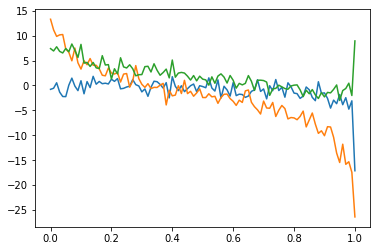

In [8]:
neutral_t.plot();
contradiction_t.plot();
entailment_t.plot();